In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5,8)
import matplotlib.font_manager
import seaborn as sns
import anndata
import scanpy as sc
import re
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


In [2]:
data_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/data/"
newdata_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/"
plot_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/"


In [3]:
query = sc.read_h5ad('/well/immune-rep/users/vbw431/Projects/Peppa/reference_hiv/Wang_postQC.h5ad')

query.obs["Ref_lab"] = "Wang"
query.obs["chemistry"] = "3P"
query.obs["bio_replicate"] = query.obs["Donor_ID"]
query.obs["sample_ID"] = query.obs["Donor_ID"]
query.obs["study_disease"] = "HIV"
query.obs["study_ID"] = query.obs["GEO_ID"]
query.obs["Treatment_status"] = "Treated"
query.obs["celltype_consensus.l1"] = "Unknown"
query.obs["celltype_consensus.l2"] = "Unknown"
query.obs["HBV_serostatus"] = "nan"
query.obs["HBV_sAg_titre"] = "nan"
query.obs["HBV_DNA_VL"] = "nan"
query.obs["scvi_batch"] = query.obs["Donor_ID"]
query.obs["sequencing_batch"] = query.obs["GEO_ID"]

query = query[query.obs["solo_classification"] != "doublet"].copy()


In [4]:
adata = sc.read_h5ad("/well/immune-rep/users/vbw431/Projects/Peppa/out/peppa_azi_combat.h5ad")
adata.obs["chemistry"] = "5P"

##load data
labels = ["NK", "CD8", "CD4", "Bcells", "Myeloid_Plt"]
cluster_list = {}
scvi_list = {}
umap_list = {}
for i in [0,1,2,3,4]:
    print("reading in " + labels[i])
    cluster_list[labels[i]] = pd.read_csv(os.path.join(newdata_dir + labels[i] +"_clustering_final/", f"Peppa_{labels[i]}_cluster_assignment.csv"), index_col =0)
    scvi_list[labels[i]] = pd.read_csv(os.path.join(newdata_dir + labels[i] +"_embeddings/", f"Peppa_{labels[i]}_scvi.csv"), index_col =0)
    umap_list[labels[i]] = pd.read_csv(os.path.join(newdata_dir + labels[i] +"_embeddings/", f"Peppa_{labels[i]}_umap.csv"), index_col =0)

adata_list = {}

for i in [0,1,2,3, 4]:
    adata_list[labels[i]] = adata[cluster_list[labels[i]].index].copy()
    adata_list[labels[i]].obsm["X_scVI"] = scvi_list[labels[i]].loc[adata_list[labels[i]].obs_names].values
    adata_list[labels[i]].obsm["X_umap"] = umap_list[labels[i]].loc[adata_list[labels[i]].obs_names].values
    adata_list[labels[i]].obs = adata_list[labels[i]].obs.merge(cluster_list[labels[i]], left_index=True, right_index=True, how="inner")
    adata_list[labels[i]].layers['counts'] = adata_list[labels[i]].X.copy()
    sc.pp.normalize_total(adata_list[labels[i]], target_sum=1e4)
    sc.pp.log1p(adata_list[labels[i]])
    adata_list[labels[i]].layers['normalized'] = adata_list[labels[i]].X.copy()
    

reading in NK
reading in CD8
reading in CD4
reading in Bcells
reading in Myeloid_Plt


In [5]:
##update meta_data with new clinical
clin_meta = pd.read_csv(newdata_dir + "index_demo.csv", index_col = 0)
clin_meta = clin_meta[["disease_group", 
                       "bio_replicate", 
                       "study_disease", 
                       "scanpy_index", 
                       "study_ID", 
                       "Treatment_status",
                      "Ethnicity",
                      "Sex",
                      "Age",
                      "HBV_serostatus",
                      "HBV_sAg_titre",
                      "HBV_DNA_VL"]]


In [6]:
new_obs = {}

for name in labels:
    del adata_list[name].obs["disease_group"]
    del adata_list[name].obs["study_disease"]
    new_df = pd.merge(adata_list[name].obs, clin_meta, how='left', left_on = ['bio_replicate','scanpy_index'], right_on = ['bio_replicate','scanpy_index'])
    new_df.index = adata_list[name].obs.index
    new_obs[name] = new_df.copy()
    adata_list[name].obs = new_df.copy()

       

In [7]:
for name in labels:
    adata_list[name].obs["celltype_consensus.l1"] = str(name)
    adata_list[name].obs["celltype_consensus.l2"] = adata_list[name].obs[str(name+".annotation.l1")]

In [8]:
##concat
adata_all = anndata.concat(adata_list, join= "outer", index_unique=None)
adata_all = adata_all[adata_all.obs["solo_classification"] != "doublet"].copy()


In [9]:
conditions = [
  ([re.search("_0|SeuratProject",a) is not None for a in adata_all.obs["orig.ident"]]),
  ([re.search("_0|SeuratProject",a) is None for a in adata_all.obs["orig.ident"]]),
 ]

# create a list of the values we want to assign for each condition
values = ["Subset", "Remove"]

# create a new column and use np.select to assign values to it using our lists as arguments
adata_all.obs["prevax"] = np.select(conditions, values)


In [10]:
import scvi

In [11]:
conditions = [
        (adata_all.obs["orig.ident"] == "SeuratProject"), 
        (adata_all.obs["orig.ident"] != "SeuratProject"), 
    ]
#create a list of the values we want to assign for each condition

values = [adata_all.obs["sample_ID"], adata_all.obs["lane"]]
    
adata_all.obs["sequencing_batch"] = np.select(conditions, values)

set(adata_all.obs["sequencing_batch"])

{'E2L1_azimuth',
 'E2L2_azimuth',
 'E2L3_azimuth',
 'E2L4_azimuth',
 'E2L5_azimuth',
 'E2L6_azimuth',
 'E2L7_azimuth',
 'E2L8_azimuth',
 'HBV_C',
 'HBV_Tre_1',
 'HBV_Tre_2',
 'HBV_Tre_3',
 'HBV_X2',
 'HH_Tre_4',
 'HIVHBV_C',
 'HIVHBV_Tre_5',
 'HIVHBV_X2',
 'Healthy',
 'L1_azimuth',
 'L2_azimuth',
 'L3_azimuth',
 'L4_azimuth',
 'L5_azimuth'}

In [12]:
tmp = adata_all.obs[["sample_ID","donor"]].bfill(axis=1).iloc[:, 0]
tmp

adata_all.obs["batch"] = tmp.copy()

In [13]:
##assign batch for azimuth and combat
conditions = [
    (adata_all.obs["orig.ident"].isin(["SeuratProject"])),
    (~adata_all.obs["orig.ident"].isin(["SeuratProject"])),
 ]

# create a list of the values we want to assign for each condition
values = [adata_all.obs["sample_ID"], adata_all.obs["orig.ident"]]

# create a new column and use np.select to assign values to it using our lists as arguments
adata_all.obs["scvi_batch"] = np.select(conditions, values)
adata_all.obs["scvi_batch"].unique().tolist()

['HIVHBV_C',
 'HH_Tre_4',
 'HBV_Tre_1',
 'HIVHBV_Tre_5',
 'HBV_Tre_3',
 'HBV_X2',
 'HBV_C',
 'HIVHBV_X2',
 'HBV_Tre_2',
 'Healthy',
 'P1_3',
 'P2_7',
 'P4_7',
 'P2_3',
 'P1_7',
 'P2_0',
 'P4_3',
 'P1_0',
 'P4_0',
 'P8_0',
 'P8_3',
 'P5_3',
 'P8_7',
 'P5_7',
 'P5_0']

In [14]:
del adata_list


In [15]:

##remove genes not present in more than 10 cells----
n_genes_pre = adata_all.shape[1]
sc.pp.filter_genes(adata_all, min_cells=10)
n_genes_post = adata.shape[1]
print("Number of genes removed: " + str(n_genes_pre - n_genes_post))
print("Number of genes pre-filtering: " + str(n_genes_pre))
print("Number of genes post filtering: " + str(n_genes_post))


Number of genes removed: 0
Number of genes pre-filtering: 23789
Number of genes post filtering: 23789


In [16]:
##remove genes not present in more than 10 cells----
n_genes_pre = query.shape[1]
sc.pp.filter_genes(query, min_cells=10)
n_genes_post = query.shape[1]
print("Number of genes removed: " + str(n_genes_pre - n_genes_post))
print("Number of genes pre-filtering: " + str(n_genes_pre))
print("Number of genes post filtering: " + str(n_genes_post))


Number of genes removed: 15824
Number of genes pre-filtering: 32738
Number of genes post filtering: 16914


In [17]:
# Extract gene sets from both AnnData objects
genes_adata1 = set(adata_all.var_names)
genes_adata2 = set(query.var_names)


In [18]:
##concat
adata = adata_all.concatenate(query, join= "outer", index_unique=None)
adata = adata[:, list(genes_adata1)].copy()

In [19]:
adata.obs["CITE_present"] = adata.obs["CITE_present"].astype(str)
adata.obs["HBV_sAg_titre"] = adata.obs["HBV_sAg_titre"].astype(str)
adata.obs["HBV_DNA_VL"] = adata.obs["HBV_DNA_VL"].astype(str)


In [20]:
adata.write("/well/immune-rep/users/vbw431/Projects/Peppa/scvi/hiv_peppa_scvi/peppa_wang_full.h5ad")


In [21]:

## HVG
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    batch_key="sequencing_batch",
    flavor = "seurat_v3",
    subset=True) 

In [22]:
scvi.model.SCVI.setup_anndata(
  adata,
  batch_key="scvi_batch",
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [23]:
N_EPOCHS=500

scvi.settings.seed = 0

early_stopping_kwargs = {
        "early_stopping": True,
        "early_stopping_monitor": "elbo_validation",
        "early_stopping_patience": 10,
        "early_stopping_min_delta": 0.001,
        }

vae = scvi.model.SCVI(
    adata,
    n_latent = 20,
)

vae.train(max_epochs=N_EPOCHS, batch_size=1024, **early_stopping_kwargs) 



[rank: 0] Global seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 373/500:  75%|▋| 373/500 [30:30<10:23,  4.91s/it, v_num=1, train_loss_step
Monitored metric elbo_validation did not improve in the last 10 records. Best score: 496.459. Signaling Trainer to stop.


In [24]:
##generate latent space and run umap

adata.obsm["X_scVI"] = vae.get_latent_representation()

sc.pp.neighbors(adata, use_rep="X_scVI", metric="cosine",n_neighbors=30)


In [25]:
sc.tl.umap(adata)

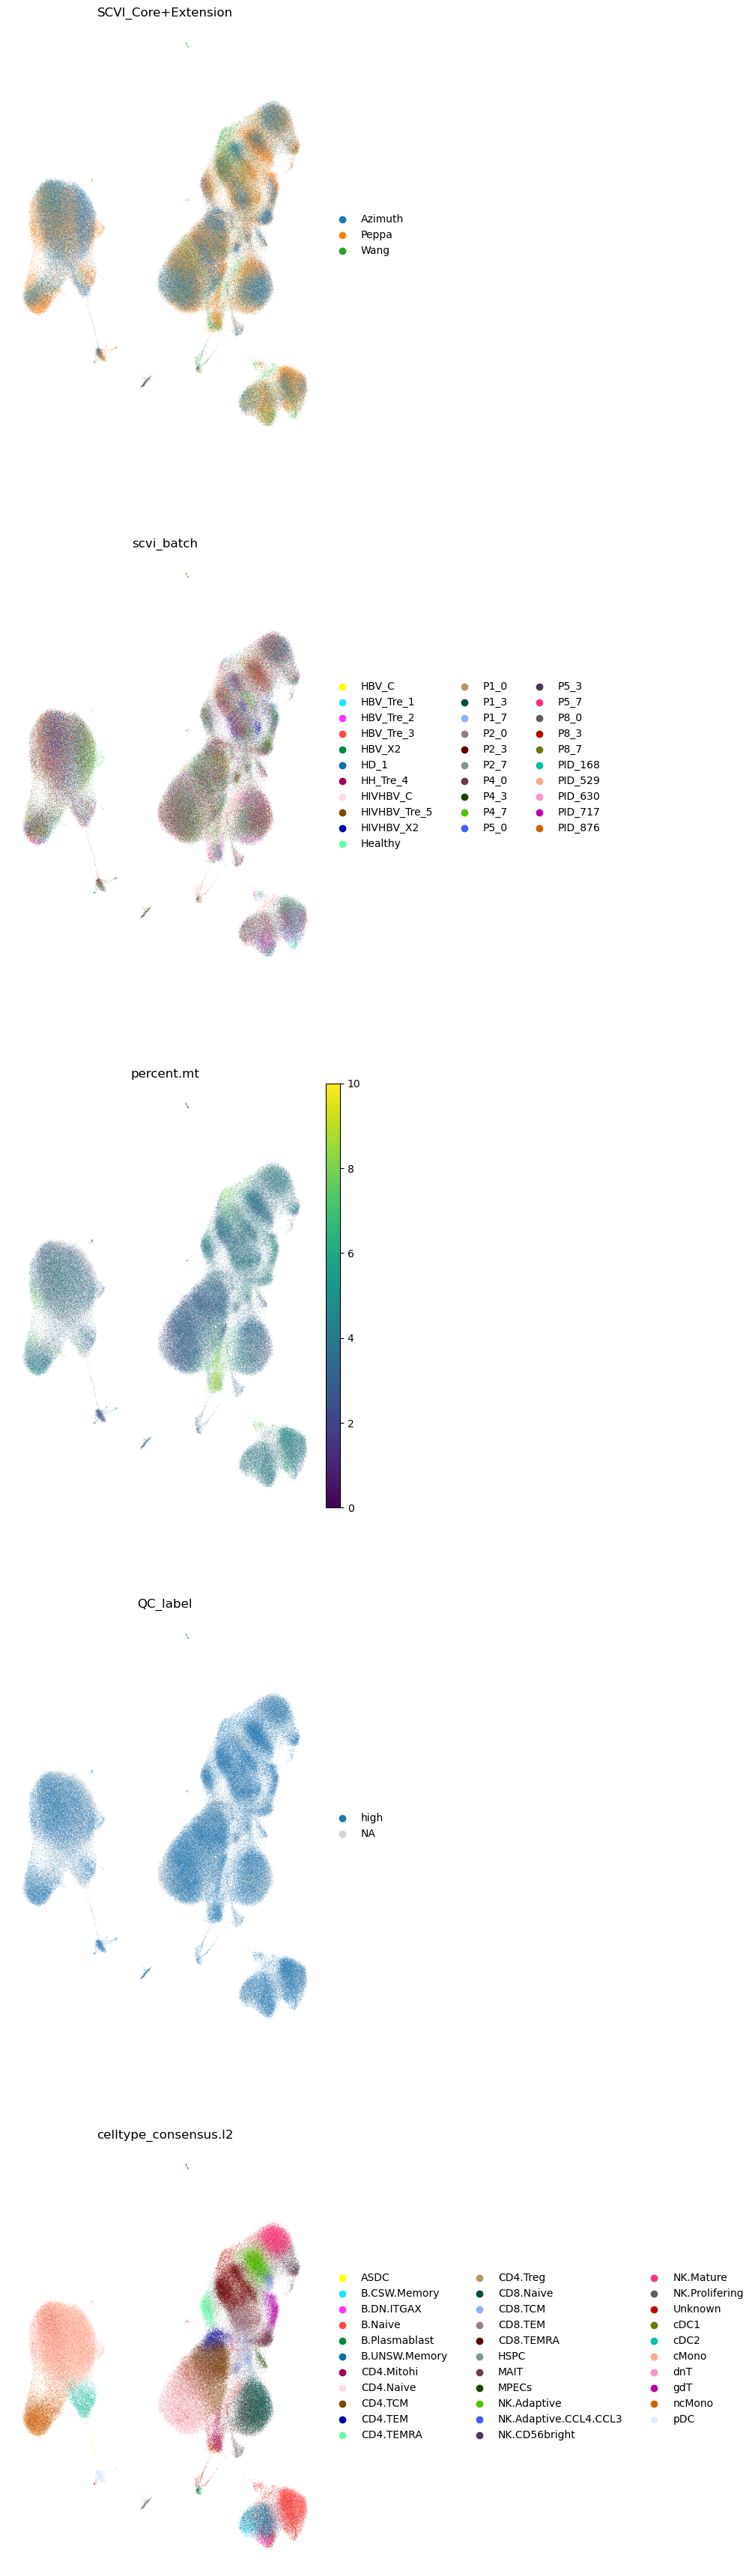

In [26]:
sc.pl.umap(
    adata,
    color=["Ref_lab", "scvi_batch","percent.mt", "QC_label","celltype_consensus.l2"],
    frameon=False,
    ncols=1,
    title="SCVI_Core+Extension",
  #     legend_fontoutline=1,
  #     size=5,
  )

In [27]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="celltype_consensus.l2",
    unlabeled_category="Unknown",
)

In [28]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)


INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 20/20: 100%|█| 20/20 [11:10<00:00, 33.50s/it, v_num=1, train_loss_step=587

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [11:10<00:00, 33.54s/it, v_num=1, train_loss_step=587


In [29]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTION_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTION_KEY] = scanvi_model.predict(adata)

In [30]:

sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY, metric="cosine",n_neighbors=20)
sc.tl.umap(adata)

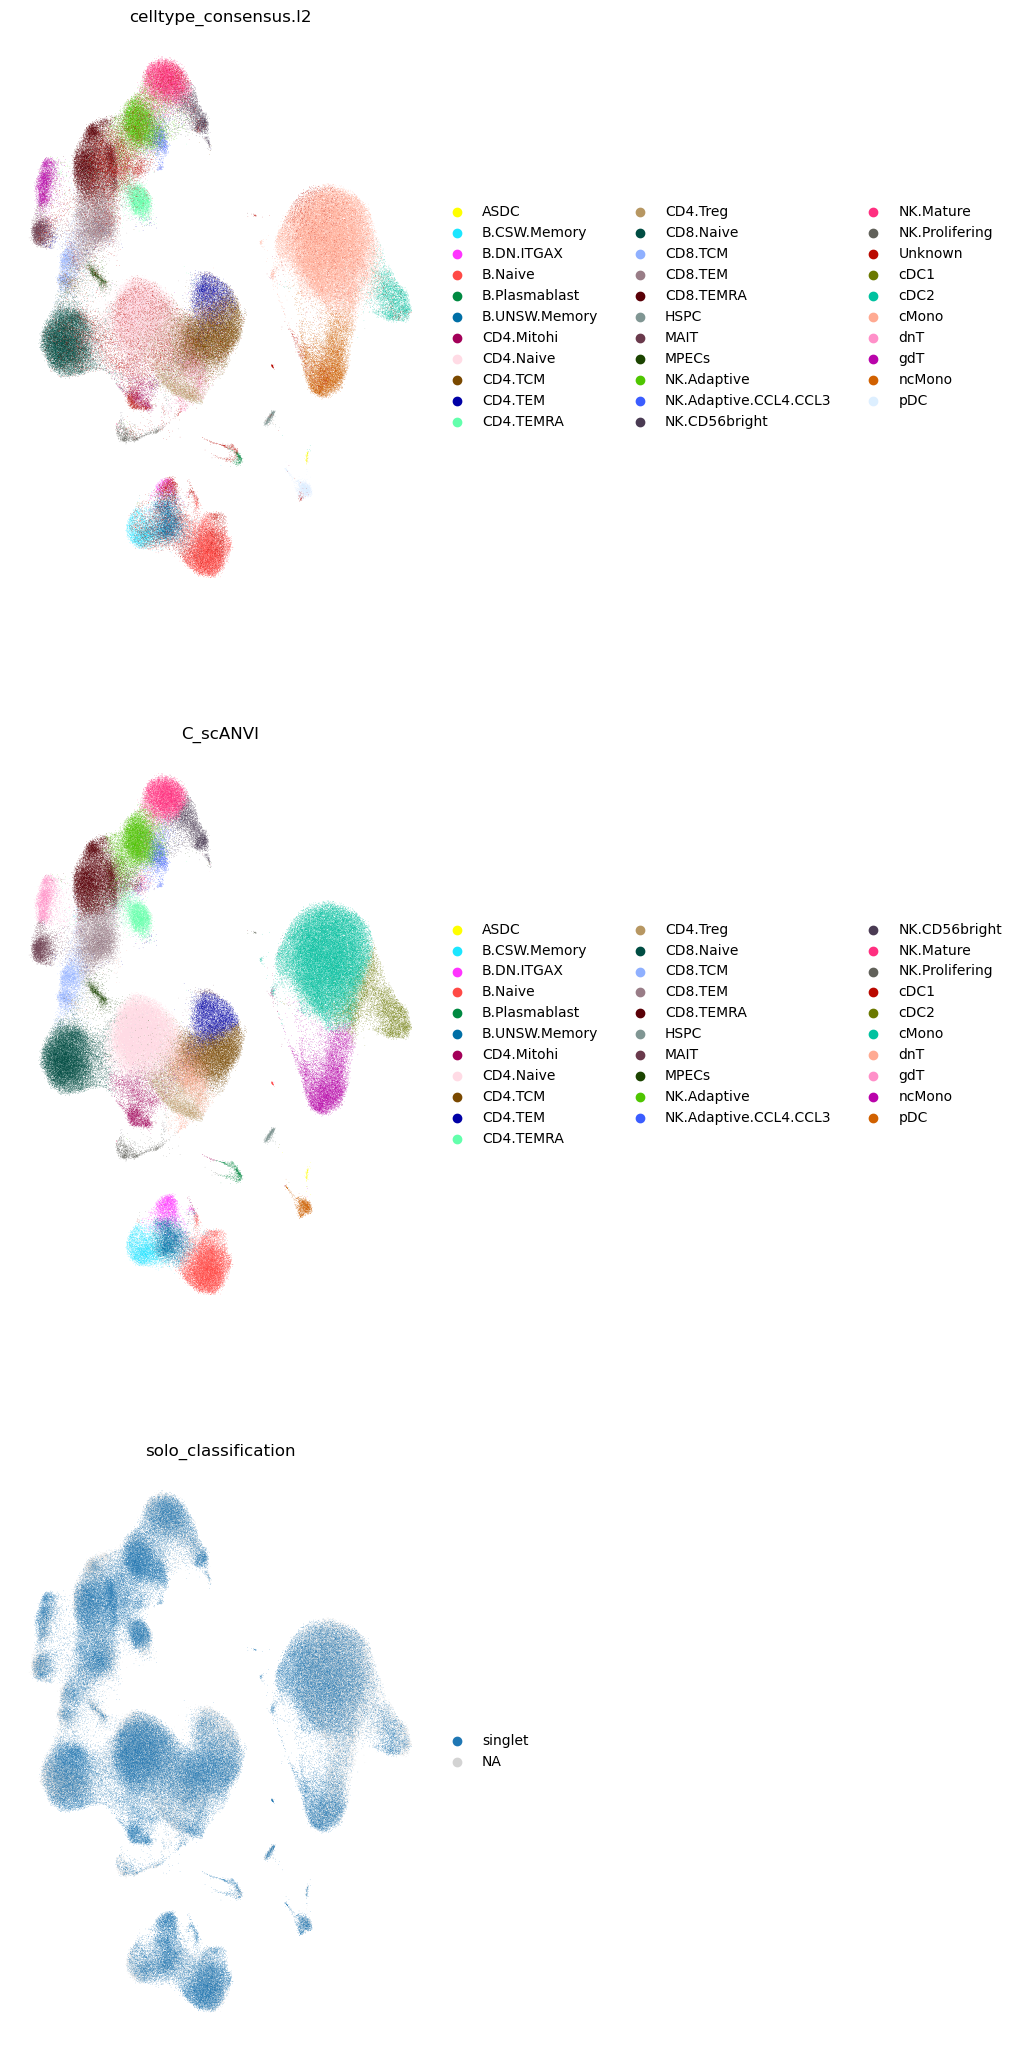

In [31]:
sc.pl.umap(
    adata,
    color=["celltype_consensus.l2", "C_scANVI", "solo_classification"],
    frameon=False,
    ncols=1
)

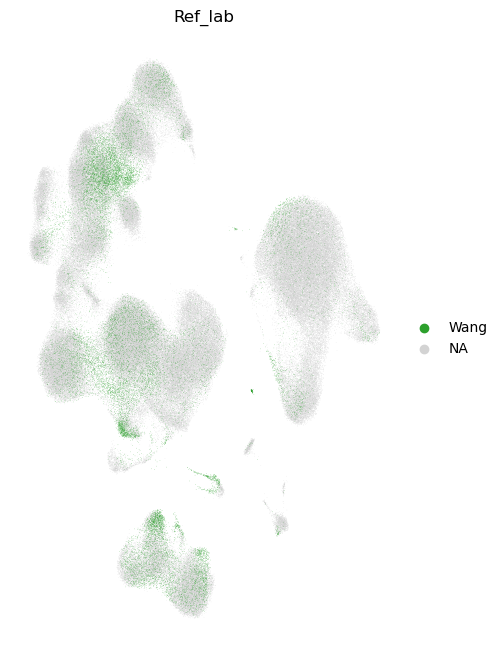

In [32]:
sc.pl.umap(
    adata,
    color=["Ref_lab"],
    groups = ["Wang"],
    frameon=False,
    ncols=2
)

In [33]:
adata.obs["Ref_lab"].value_cou

AnnData object with n_obs × n_vars = 261531 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample_ID', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'percent.ribo', 'percent.Ig', 'S.Score', 'G2M.Score', 'Phase', 'CITE_present', 'nCount_CITE', 'nFeature_CITE', 'nCount_protein_counts', 'nFeature_protein_counts', 'Hashtag.1', 'Hashtag.2', 'QC_label', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'solo_doublet_prob', 'solo_singlet_prob', 'solo_classification', 'nCount_CITE_seurat', 'nFeature_CITE_seurat', 'batch', 'scanpy_index', 'bio_replicate', 'CMV_status', 'Ref_lab', 'sample_id', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'nCount_SCT', 'nFeature_SCT', 'X_index', 'n_genes_by_counts', 'total_counts'

In [34]:
vae.save("/well/immune-rep/users/vbw431/Projects/Peppa/scvi/hiv_peppa_scvi/", overwrite=True)
scanvi_model.save("/well/immune-rep/users/vbw431/Projects/Peppa/scvi/SCANVI/", overwrite=True)


In [35]:
adata.write("/well/immune-rep/users/vbw431/Projects/Peppa/scvi/hiv_peppa_scvi/peppa_wang_annotated.h5ad")